In [1]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


c:\Users\dell\anaconda3\envs\azhan\lib\site-packages\nbformat\__init__.py:92: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


Platform: Local machine


c:\Users\dell\anaconda3\envs\azhan\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  RequestsDependencyWarning,


TorchMetrics already installed.
Note: you may need to restart the kernel to use updated packages.
(set(), set())
Index: 1683
Input Image: Datasets/RESIDE-6K/train/hazy/2513.jpg
Target Image: Datasets/RESIDE-6K/train/GT/2513.jpg
Input Image: Datasets/RESIDE-6K/train/hazy/166.jpg
Target Image: Datasets/RESIDE-6K/train/GT/166.jpg


C:\Users\dell\AppData\Roaming\Python\Python37\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Datasets/RESIDE-6K/train/hazy/3688.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.2996 | PSNR: 9.4707 | SSIM: 49.90%


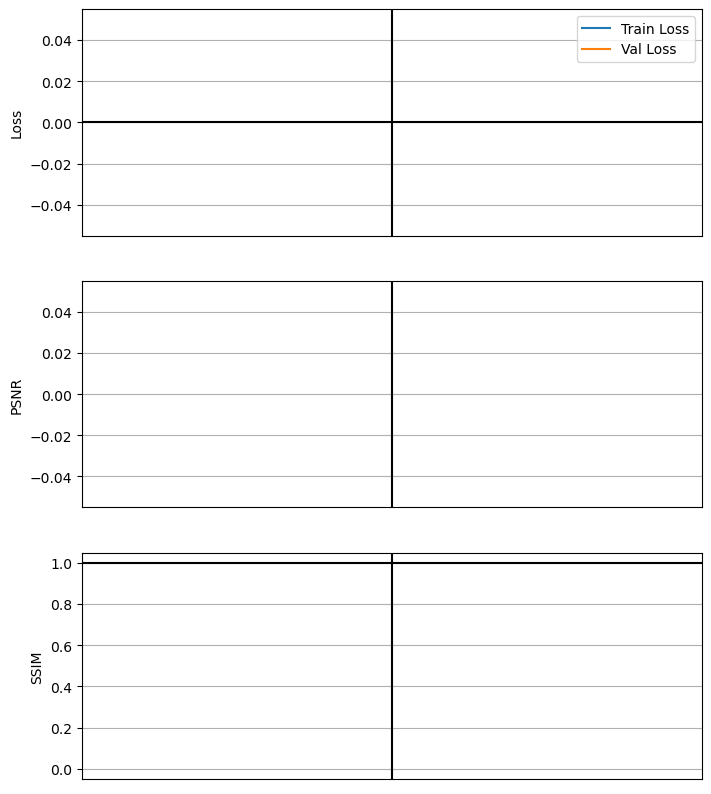

(set(), set())
Index: 795
Input Image: Datasets/RESIDE-6K/test/hazy/1443_10.png
Target Image: Datasets/RESIDE-6K/test/GT/1443_10.png
Datasets/RESIDE-6K/test/hazy/0022_0.8_0.08.jpg
Image size: [1, 3, 412, 548]
L1 Loss: 0.2634 | PSNR: 10.7306 | SSIM: 56.56%


In [2]:
%run model_development.ipynb


In [4]:
import import_ipynb
import cv2
from timeit import default_timer as timer
from collections import OrderedDict

from model_development import *
#from extra_models import *

In [5]:
videos_path = 'Videos'

In [6]:
FROM_VIDEO = True
video_name = 'Virtual_Drive_Through_The_Dark_and_Foggy_Forest__Rain_and_Thunder_01_36_00___01_38_00.mp4'
video_loc = f'{videos_path}/{video_name}'

SKIP_INTERVAL = 24

In [7]:
model = LightClearNetWithSkips().to(device)
state_dict_name = 'LightClearNetWithSkips_2024-03-31_15-06-48.pth'
IS_STATE_DICT_LOADING_EASY = True
NORMALIZE = False
RESIZE = True
IMG_HEIGHT = 400

Datasets/RESIDE-6K/train/hazy/1125.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.2386 | PSNR: 11.2634 | SSIM: 23.44%


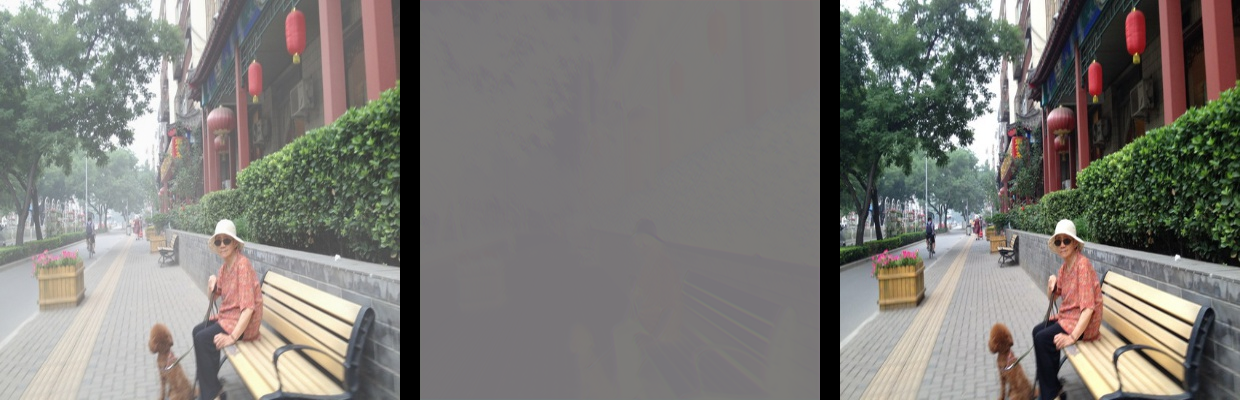

In [8]:
visualize_random_pair_pred(dataset, model, visualize_target=True, normalize=NORMALIZE)

In [9]:
state_dict_loc = os.path.join(model_save_path, state_dict_name)
print(state_dict_loc)

if IS_STATE_DICT_LOADING_EASY:
    state_dict = torch.load(state_dict_loc, map_location=torch.device('cpu'))
else:
    state_dict = torch.load(state_dict_loc)['state_dict']
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k[7:]
        new_state_dict[name] = v

    state_dict = new_state_dict

state_dict

models\LightClearNetWithSkips_2024-03-31_15-06-48.pth


OrderedDict([('enc_conv1.weight',
              tensor([[[[ 1.3551e-01,  3.0696e-01,  1.0694e-01],
                        [-9.0794e-02,  3.0672e-03, -1.6050e-01],
                        [-9.1134e-02, -1.6327e-01, -1.5646e-01]],
              
                       [[ 1.9694e-01,  3.5908e-01,  5.7836e-02],
                        [-5.8479e-02, -6.9847e-02,  6.6849e-02],
                        [-9.0300e-02, -2.5681e-01, -1.3488e-02]],
              
                       [[ 2.0727e-01,  3.4146e-01, -7.3150e-02],
                        [-2.2329e-01,  1.4039e-01, -6.7089e-02],
                        [-1.1975e-01, -3.0782e-01, -4.5951e-02]]],
              
              
                      [[[-1.9711e-01,  4.8671e-02,  2.0660e-01],
                        [ 3.4264e-01,  1.7089e-01,  4.9375e-02],
                        [-1.1877e-01, -2.7335e-01,  8.5867e-02]],
              
                       [[ 1.0280e-01, -1.3817e-01, -1.0423e-01],
                        [ 3.2454e-01, -1.

In [10]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Datasets/RESIDE-6K/test/hazy/0017_0.9_0.08.jpg
Image size: [1, 3, 480, 548]
L1 Loss: 0.0556 | PSNR: 22.0229 | SSIM: 86.38%


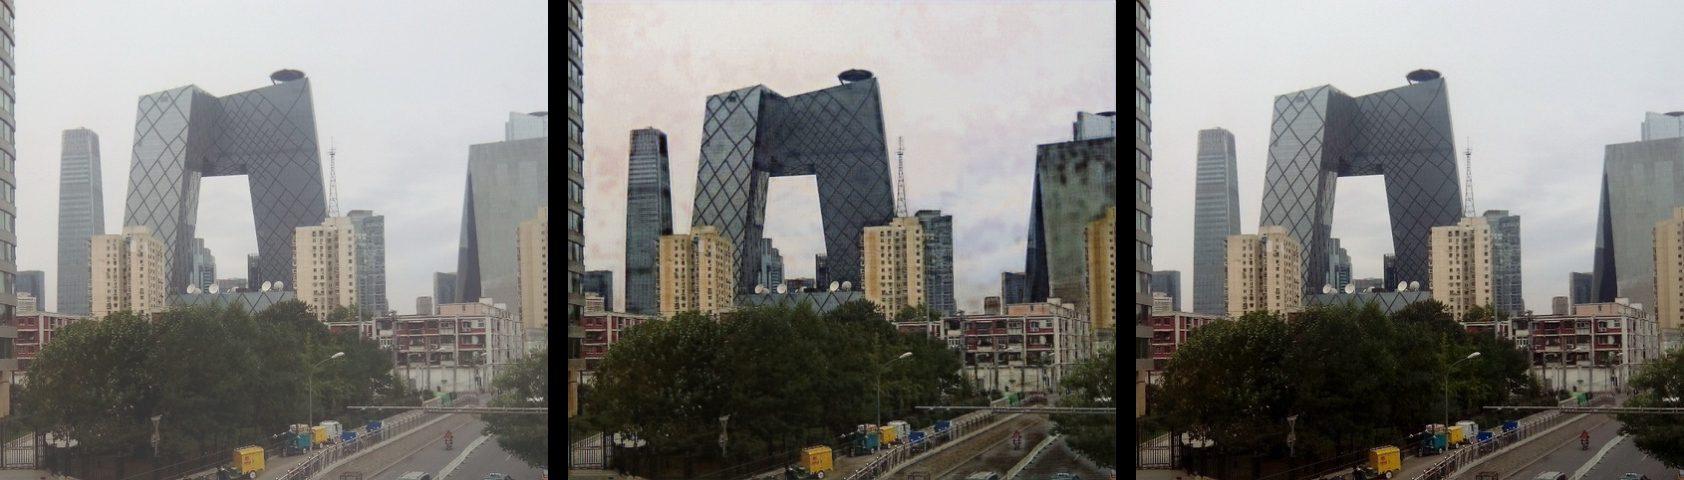

In [11]:
visualize_random_pair_pred(test_dataset, model, visualize_target=True, normalize=NORMALIZE)

In [12]:
def resize_image(image, target_height=IMG_HEIGHT):
    scale = target_height / image.height
    return image.resize((int(image.width * scale), int(image.height * scale)))

In [13]:
def frame_dehazer(frame, model):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(frame_rgb)
    if RESIZE:
        pil_img = resize_image(pil_img)
    input = img_to_tensor(pil_img).unsqueeze(0).to(device)

    model.eval()
    with torch.inference_mode():
        output = model(input)
    if NORMALIZE:
        output = normalize_tensor(output)

    dehazed_pil_img = tensor_to_img(output.squeeze())
    new_image = visualize_pair(pil_img, dehazed_pil_img, gap=0)

    return cv2.cvtColor(np.array(new_image), cv2.COLOR_BGR2RGB)

In [14]:
cap = cv2.VideoCapture(0 if not FROM_VIDEO else video_loc)

In [15]:
start_time = timer()
                   
rendered_frames = 0
video_frames = -1

while True:
    ret, frame = cap.read()

    if not ret:
        break

    video_frames += 1
    if FROM_VIDEO and video_frames % SKIP_INTERVAL != 0:
        continue

    dehazed_frame = frame_dehazer(frame, model)
    cv2.imshow('Original vs. Dehazed Video', dehazed_frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if cv2.waitKey(1) & 0xFF == ord(' '):
        while True:
            if cv2.waitKey(1) & 0xFF == ord(' '):
                break
        

    rendered_frames += 1

cv2.destroyAllWindows()

elapsed_time = timer() - start_time

print(f'Time Elapsed: {elapsed_time:.2f}s')
print(f'Frames: {rendered_frames} | Avg FPS: {rendered_frames/elapsed_time:.2f}')
if FROM_VIDEO:
    print(f'Video Frames: {video_frames} | Video Avg FPS: {video_frames/elapsed_time:.2f}')

Time Elapsed: 149.82s
Frames: 126 | Avg FPS: 0.84
Video Frames: 3000 | Video Avg FPS: 20.02


In [16]:
cap.release()

In [18]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

def load_image(image_path):
    """Load image from file."""
    img = Image.open(image_path).convert('RGB')
    return img

def preprocess_image(img):
    """Preprocess image for model input."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img = transform(img).unsqueeze(0)
    return img

def tensor_to_img(tensor):
    """Convert tensor to PIL image."""
    tensor = tensor.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
    tensor = (tensor + 1) / 2 * 255
    tensor = np.clip(tensor, 0, 255).astype(np.uint8)
    img = Image.fromarray(tensor)
    return img

def frame_dehazer(frame, model):
    """Dehaze a single frame."""
    with torch.no_grad():
        input_tensor = preprocess_image(frame)
        output_tensor = model(input_tensor.to(device))
        output_img = tensor_to_img(output_tensor)
    return output_img

# Prompt user to input path to hazy image
hazy_image_path = input(import os
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

def load_image(image_path):
    """Load image from file."""
    img = Image.open(image_path).convert('RGB')
    return img

def preprocess_image(img):
    """Preprocess image for model input."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img = transform(img).unsqueeze(0)
    return img

def tensor_to_img(tensor):
    """Convert tensor to PIL image."""
    tensor = tensor.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
    tensor = (tensor + 1) / 2 * 255
    tensor = np.clip(tensor, 0, 255).astype(np.uint8)
    img = Image.fromarray(tensor)
    return img

def frame_dehazer(frame, model):
    """Dehaze a single frame."""
    with torch.no_grad():
        input_tensor = preprocess_image(frame)
        output_tensor = model(input_tensor.to(device))
        output_img = tensor_to_img(output_tensor)
    return output_img

# Prompt user to input path to hazy image
hazy_image_path = input("C:/Users/dell/Downloads/images.jpg")

# Check if the provided path exists
if not os.path.exists(hazy_image_path):
    print("Error: The provided path does not exist.")
    exit()

# Load the hazy image
hazy_image = load_image(hazy_image_path)

# Dehaze the image using the pre-trained model
dehazed_image = frame_dehazer(hazy_image, model)

# Display the original and dehazed images
original_img = cv2.imread(hazy_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

concatenated_img = np.concatenate((original_img, np.array(dehazed_image)), axis=1)
cv2.imshow('Original vs Dehazed Image', concatenated_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
)

# Check if the provided path exists
if not os.path.exists(hazy_image_path):
    print("Error: The provided path does not exist.")
    exit()

# Load the hazy image
hazy_image = load_image(hazy_image_path)

# Dehaze the image using the pre-trained model
dehazed_image = frame_dehazer(hazy_image, model)

# Display the original and dehazed images
original_img = cv2.imread(hazy_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

concatenated_img = np.concatenate((original_img, np.array(dehazed_image)), axis=1)
cv2.imshow('Original vs Dehazed Image', concatenated_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


SyntaxError: invalid syntax (3472382766.py, line 39)

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

def load_image(image_path):
    """Load image from file."""
    img = Image.open(image_path).convert('RGB')
    return img

def preprocess_image(img):
    """Preprocess image for model input."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img = transform(img).unsqueeze(0)
    return img

def tensor_to_img(tensor):
    """Convert tensor to PIL image."""
    tensor = tensor.squeeze().detach().cpu().numpy().transpose((1, 2, 0))
    tensor = (tensor + 1) / 2 * 255
    tensor = np.clip(tensor, 0, 255).astype(np.uint8)
    img = Image.fromarray(tensor)
    return img

def frame_dehazer(frame, model):
    """Dehaze a single frame."""
    with torch.no_grad():
        input_tensor = preprocess_image(frame)
        output_tensor = model(input_tensor.to(device))
        output_img = tensor_to_img(output_tensor)
    return output_img

# Prompt user to input path to hazy image
hazy_image_path = input("C:/Users/dell/Downloads/images.jpg")

# Check if the provided path exists
if not os.path.exists(hazy_image_path):
    print("Error: The provided path does not exist.")
    exit()

# Load the hazy image
hazy_image = load_image(hazy_image_path)

# Dehaze the image using the pre-trained model
dehazed_image = frame_dehazer(hazy_image, model)

# Display the original and dehazed images
original_img = cv2.imread(hazy_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

concatenated_img = np.concatenate((original_img, np.array(dehazed_image)), axis=1)
cv2.imshow('Original vs Dehazed Image', concatenated_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


c:\Users\dell\anaconda3\envs\azhan\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (3.3.2) doesn't match a supported version!
  RequestsDependencyWarning,
